In [1]:
import numpy as np
import pandas as pd


for hour in [2, 7, 10]:
    print("="*40)
    print(f"Solution begins for {hour} o'clock!")
    tij_path = f"Tij_matrix_hour_{hour}_critical_points_for_success.csv"
    Tij_df = pd.read_csv(tij_path, index_col=0)
    Tij = Tij_df.values
    num_stations, num_demands = Tij.shape

    station_capacities = [10, 10, 10, 4, 2, 4, 2, 8, 8, 8, 4]  

    max_iter = 100
    num_particles = 100
    w = 0.9
    w_min = 0.4
    c1 = 2.0
    c2 = 2.0

    def calculate_station_counts(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        return np.bincount(assignment, minlength=num_stations)

    def is_valid(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        counts = calculate_station_counts(assignment)
        if np.any(counts > station_capacities):
            return False
        if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
            return False
        return True

    def fitness_function(assignment, alpha=0.8):
      assignment = np.asarray(assignment).flatten().astype(int)
      counts = calculate_station_counts(assignment)
      penalty = 0
      over_mask = counts > station_capacities
      if np.any(over_mask):
          penalty += 10000 * np.sum(counts[over_mask] - np.array(station_capacities)[over_mask])
      if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
          penalty += 100000
      total_time = np.sum(Tij[assignment, np.arange(num_demands)])
      worst_time = np.max(Tij[assignment, np.arange(num_demands)])
      return alpha * total_time + (1 - alpha) * worst_time + penalty




    def repair_assignment(assignment):
      assignment = np.asarray(assignment).flatten().astype(int)
      num_stations = len(station_capacities)
      num_demands = len(assignment)
      counts = np.zeros(num_stations, dtype=int)
      repaired = np.full(num_demands, -1)
      for demand_idx in range(num_demands):
          
          candidates = [s for s in range(num_stations)
                        if counts[s] < station_capacities[s] and not np.isinf(Tij[s, demand_idx])]
          if candidates:
              
              best_station = min(candidates, key=lambda s: Tij[s, demand_idx])
              repaired[demand_idx] = best_station
              counts[best_station] += 1
          else:
              
              min_penalty = float('inf')
              best_station = -1
              for s in range(num_stations):
                  if not np.isinf(Tij[s, demand_idx]):
                      penalty = counts[s] - station_capacities[s]
                      if penalty < min_penalty:
                          min_penalty = penalty
                          best_station = s
              if best_station != -1:
                  repaired[demand_idx] = best_station
                  counts[best_station] += 1
              else:
                  
                  repaired[demand_idx] = np.random.randint(0, num_stations)
      return repaired




    
    def binary_pso():
        positions = np.random.uniform(-5, 5, size=(num_particles, num_stations, num_demands))
        velocities = np.random.uniform(-1, 1, size=(num_particles, num_stations, num_demands))
        binary_particles = [np.random.randint(0, num_stations, num_demands) for _ in range(num_particles - 1)]
        greedy_assignment = np.argmin(Tij, axis=0)
        binary_particles.insert(0, greedy_assignment)
        
        particles = []
        for p in binary_particles:
            repaired_p = repair_assignment(p)
            particles.append(repaired_p)
        
        fitness_values = [fitness_function(p, alpha=0.8) for p in particles]

        best_idx = np.argmin(fitness_values)
        global_best = np.array(particles[best_idx]).copy()
        global_best_fitness = fitness_values[best_idx]
        personal_bests = [np.array(p).copy() for p in particles]
        personal_fitness = fitness_values.copy()
        print(f"Global Best Fitness: {global_best_fitness:.2f}")

        for iteration in range(max_iter):
            current_w = w - iteration * ((w - w_min) / max_iter)
            for i in range(num_particles):
                r1 = np.random.rand(num_stations, num_demands)
                r2 = np.random.rand(num_stations, num_demands)
                pb_one_hot = (np.arange(num_stations)[:, None] == personal_bests[i][None, :]).astype(float)
                gb_one_hot = (np.arange(num_stations)[:, None] == global_best[None, :]).astype(float)
                velocities[i] = (current_w * velocities[i] + c1 * r1 * (pb_one_hot - positions[i]) + c2 * r2 * (gb_one_hot - positions[i]))
                positions[i] += velocities[i]
                new_assign = np.argmax(positions[i], axis=0)
                repaired_assignment = repair_assignment(new_assign)
                particles[i] = repaired_assignment
                current_fitness = fitness_function(particles[i])
                if is_valid(particles[i]) and current_fitness < personal_fitness[i]:
                    personal_bests[i] = np.array(particles[i]).copy()
                    personal_fitness[i] = current_fitness
                if is_valid(particles[i]) and current_fitness < global_best_fitness:
                    global_best = np.array(particles[i]).copy()
                    global_best_fitness = current_fitness
            if (iteration+1) % 10 == 0 or iteration == 0:
                print(f"Iteration {iteration+1}/{max_iter}, Best Fitness: {global_best_fitness:.2f}")
        return global_best, global_best_fitness

    
    best_assignment, best_cost = binary_pso()

    if best_cost != np.inf:
        print("\nBPSO Completed!")
        print(f"Best Total Travel Time: {best_cost:.2f}")
        station_counts = calculate_station_counts(best_assignment)
        print("\nNumber of requests assigned per station:")
        for station, count in enumerate(station_counts):
            print(f"Station {station}: {count} Request")
        if is_valid(best_assignment):
            print("\nThe Solution is valid: all constraints are met.")
        else:
            print("\nWarning: the solution does not satisfy the constraints.")

        print("\nStations to which demand zones are assigned:")
        for demand_idx, station_idx in enumerate(best_assignment):
            print(f"Demand zone {demand_idx}: station {station_idx} (time: {Tij[station_idx, demand_idx]:.2f})")
    else:
        print("\nWarning: no valid solution found.")

    print(f"Best total travel time: {best_cost:.2f}")
    greedy_assignment = np.argmin(Tij, axis=0)
    greedy_cost = np.sum(Tij[greedy_assignment, np.arange(num_demands)])
    print("Greedy total time (unlimited):", greedy_cost)
    print("PSO - Greedy difference:", best_cost - greedy_cost)
    if greedy_cost > 0 and best_cost < np.inf:
        percentage = (greedy_cost / best_cost) * 100
        print(f"PSO solution is as close as %{percentage:.2f} to greedy optimum.")
        fark = best_cost - greedy_cost
        print(f"Extra cost: {fark:.2f} (as a percentage: %{(fark/greedy_cost)*100:.2f})")
    else:
        print("Calculation failed. Invalid result may occur.")


Solution begins for 2 o'clock!
Global Best Fitness: 14312.90
Iteration 1/100, Best Fitness: 14312.90
Iteration 10/100, Best Fitness: 14312.90
Iteration 20/100, Best Fitness: 14312.90
Iteration 30/100, Best Fitness: 14312.90
Iteration 40/100, Best Fitness: 14312.90
Iteration 50/100, Best Fitness: 14312.90
Iteration 60/100, Best Fitness: 14312.90
Iteration 70/100, Best Fitness: 14312.90
Iteration 80/100, Best Fitness: 14312.90
Iteration 90/100, Best Fitness: 14312.90
Iteration 100/100, Best Fitness: 14312.90

BPSO Completed!
Best Total Travel Time: 14312.90

Number of requests assigned per station:
Station 0: 1 Request
Station 1: 10 Request
Station 2: 10 Request
Station 3: 4 Request
Station 4: 2 Request
Station 5: 4 Request
Station 6: 2 Request
Station 7: 8 Request
Station 8: 8 Request
Station 9: 8 Request
Station 10: 2 Request

The Solution is valid: all constraints are met.

Stations to which demand zones are assigned:
Demand zone 0: station 2 (time: 174.58)
Demand zone 1: station 2 (t

In [3]:
pip install contextily

  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached rasterio-1.4.3-cp312-cp312-win_amd64.whl.metadata (9.4 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached contextily-1.6.2-py3-none-any.whl (17 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Using cached rasterio-1.4.3-cp312-cp312-win_amd64.whl (25.4 MB)
   ---------------------------------------- 0.0/90.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/90.4 kB ? eta -:--:--
   ------------------ --------------------- 41.0/90.4 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 90.4/90.4 kB 852.7 kB/s eta 0:00:00
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached cli


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\fikir\AppData\Local\Temp\ipykernel_7468\227085126.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)


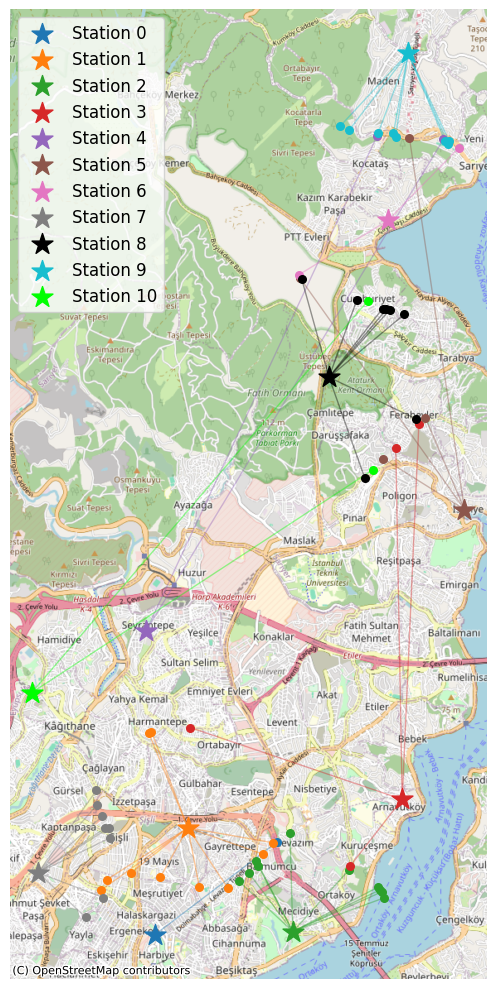

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors


demand = pd.read_csv('final_critical_demand_zones_80_for_success.csv')
stations = pd.read_csv('filtered_itfaiye.csv')


best_assignment = np.array([ 2, 2, 2, 1, 9, 5, 9, 9, 9, 1, 2, 2, 1, 6, 8, 2, 2, 8, 9, 5, 9, 6, 8, 8, 1, 8, 7, 8, 2, 1, 7, 9, 1, 8, 1, 8, 7, 9, 1, 5, 7, 2, 5, 4, 1, 2, 4, 7, 1, 7, 3, 3, 10, 10, 3, 3, 0, 7, 7

 ]) 


gdf_demands = gpd.GeoDataFrame(
    demand,
    geometry=gpd.points_from_xy(demand['LONGITUDE'], demand['LATITUDE']),
    crs="EPSG:4326"
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Koordinat (Y)'], stations['Koordinat (X)']),
    crs="EPSG:4326"
)


gdf_demands = gdf_demands.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)



num_stations = len(gdf_stations)
cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)
colors = [mcolors.rgb2hex(cmap(i)) for i in range(num_stations)]


colors[8] = 'black'     
colors[10] = 'lime'      


fig, ax = plt.subplots(figsize=(12, 10))


for st_idx in range(num_stations):
    
    assigned_idx = np.where(best_assignment == st_idx)[0]
    color = colors[st_idx]

    
    gdf_demands.iloc[assigned_idx].plot(ax=ax, color=color, markersize=30, zorder=2)
    
    
    for i in assigned_idx:
        demand_point = gdf_demands.iloc[i].geometry
        station_point = gdf_stations.iloc[st_idx].geometry
        ax.plot([demand_point.x, station_point.x], [demand_point.y, station_point.y],
                color=color, alpha=0.4, linewidth=1, zorder=1)
    
    
    gdf_stations.iloc[[st_idx]].plot(ax=ax, color=color, marker='*', markersize=250, zorder=3, label=f'Station {st_idx}')


ctx.add_basemap(ax, crs=gdf_demands.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()




C:\Users\fikir\AppData\Local\Temp\ipykernel_7468\1701963210.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)


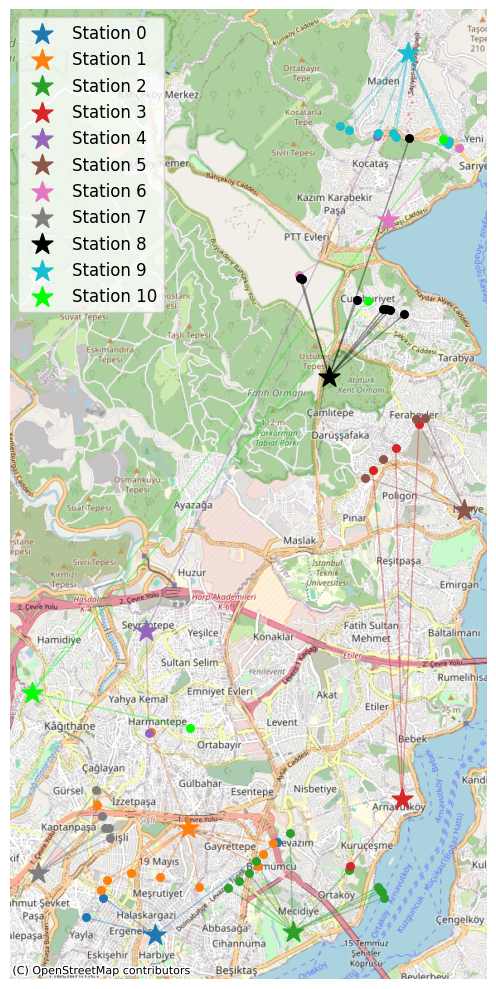

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors


demand = pd.read_csv('final_critical_demand_zones_80_for_success.csv')
stations = pd.read_csv('filtered_itfaiye.csv')


best_assignment = np.array([ 2, 2, 2, 1, 9, 5, 9, 9, 9, 1, 2, 2, 2, 6, 8, 2, 2, 8, 9, 5, 9, 6, 5, 8, 1, 5, 0, 8, 2, 1, 7, 9, 4, 8, 1, 8, 7, 9, 1, 8, 7, 2, 8, 4, 1, 1, 10, 7, 1, 1, 10, 3, 10, 3, 3, 3, 0, 7, 0

 ]) 


gdf_demands = gpd.GeoDataFrame(
    demand,
    geometry=gpd.points_from_xy(demand['LONGITUDE'], demand['LATITUDE']),
    crs="EPSG:4326"
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Koordinat (Y)'], stations['Koordinat (X)']),
    crs="EPSG:4326"
)


gdf_demands = gdf_demands.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)


num_stations = len(gdf_stations)
cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)
colors = [mcolors.rgb2hex(cmap(i)) for i in range(num_stations)]


colors[8] = 'black'     
colors[10] = 'lime'      


fig, ax = plt.subplots(figsize=(12, 10))


for st_idx in range(num_stations):
    
    assigned_idx = np.where(best_assignment == st_idx)[0]
    color = colors[st_idx]

    
    gdf_demands.iloc[assigned_idx].plot(ax=ax, color=color, markersize=30, zorder=2)
    
    
    for i in assigned_idx:
        demand_point = gdf_demands.iloc[i].geometry
        station_point = gdf_stations.iloc[st_idx].geometry
        ax.plot([demand_point.x, station_point.x], [demand_point.y, station_point.y],
                color=color, alpha=0.4, linewidth=1, zorder=1)
    
    
    gdf_stations.iloc[[st_idx]].plot(ax=ax, color=color, marker='*', markersize=250, zorder=3, label=f'Station {st_idx}')


ctx.add_basemap(ax, crs=gdf_demands.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()




C:\Users\fikir\AppData\Local\Temp\ipykernel_7468\3356947077.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)


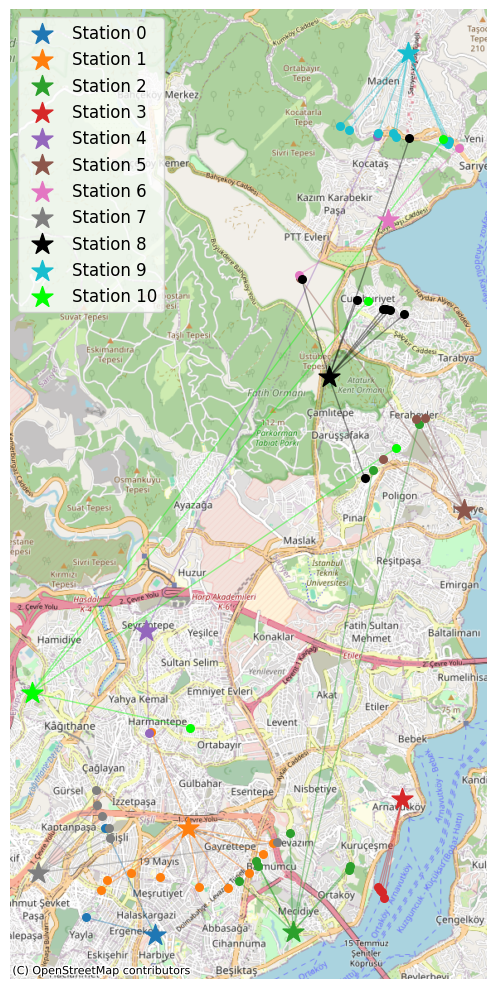

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors


demand = pd.read_csv('final_critical_demand_zones_80_for_success.csv')
stations = pd.read_csv('filtered_itfaiye.csv')


best_assignment = np.array([ 3, 2, 1, 1, 9, 5, 9, 9, 9, 1, 2, 3, 1, 6, 8, 3, 2, 8, 9, 5, 9, 6, 8, 8, 1, 5, 0, 8, 2, 1, 7, 9, 4, 8, 1, 8, 7, 9, 1, 8, 7, 3, 5, 4, 1, 2, 10, 7, 1, 7, 10, 10, 10, 2, 2, 2, 7, 0

 ]) 


gdf_demands = gpd.GeoDataFrame(
    demand,
    geometry=gpd.points_from_xy(demand['LONGITUDE'], demand['LATITUDE']),
    crs="EPSG:4326"
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Koordinat (Y)'], stations['Koordinat (X)']),
    crs="EPSG:4326"
)


gdf_demands = gdf_demands.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)


num_stations = len(gdf_stations)
cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)
colors = [mcolors.rgb2hex(cmap(i)) for i in range(num_stations)]


colors[8] = 'black'    
colors[10] = 'lime'       


fig, ax = plt.subplots(figsize=(12, 10))


for st_idx in range(num_stations):
    
    assigned_idx = np.where(best_assignment == st_idx)[0]
    color = colors[st_idx]

    
    gdf_demands.iloc[assigned_idx].plot(ax=ax, color=color, markersize=30, zorder=2)
    
    
    for i in assigned_idx:
        demand_point = gdf_demands.iloc[i].geometry
        station_point = gdf_stations.iloc[st_idx].geometry
        ax.plot([demand_point.x, station_point.x], [demand_point.y, station_point.y],
                color=color, alpha=0.4, linewidth=1, zorder=1)
    
    
    gdf_stations.iloc[[st_idx]].plot(ax=ax, color=color, marker='*', markersize=250, zorder=3, label=f'Station {st_idx}')


ctx.add_basemap(ax, crs=gdf_demands.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()




In [8]:
import numpy as np
import pandas as pd


tij_path = "STATIC_Tij_matrix_80_for_success.csv"
Tij_df = pd.read_csv(tij_path, index_col=0)
Tij = Tij_df.values
num_stations, num_demands = Tij.shape

station_capacities = [10, 10, 10, 4, 2, 4, 2, 8, 8, 8, 4]  

max_iter = 100
num_particles = 100
w = 0.9
w_min = 0.4
c1 = 2.0
c2 = 2.0

def calculate_station_counts(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    return np.bincount(assignment, minlength=num_stations)

def is_valid(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = calculate_station_counts(assignment)
    if np.any(counts > station_capacities):
        return False
    if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
        return False
    return True

def fitness_function(assignment, alpha=0.8):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = calculate_station_counts(assignment)
    penalty = 0
    over_mask = counts > station_capacities
    if np.any(over_mask):
        penalty += 10000 * np.sum(counts[over_mask] - np.array(station_capacities)[over_mask])
    if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
        penalty += 100000
    total_time = np.sum(Tij[assignment, np.arange(num_demands)])
    worst_time = np.max(Tij[assignment, np.arange(num_demands)])
    return alpha * total_time + (1 - alpha) * worst_time + penalty

def repair_assignment(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    num_stations = len(station_capacities)
    num_demands = len(assignment)
    counts = np.zeros(num_stations, dtype=int)
    repaired = np.full(num_demands, -1)
    for demand_idx in range(num_demands):
        
        candidates = [s for s in range(num_stations)
                      if counts[s] < station_capacities[s] and not np.isinf(Tij[s, demand_idx])]
        if candidates:
            
            best_station = min(candidates, key=lambda s: Tij[s, demand_idx])
            repaired[demand_idx] = best_station
            counts[best_station] += 1
        else:
            
            min_penalty = float('inf')
            best_station = -1
            for s in range(num_stations):
                if not np.isinf(Tij[s, demand_idx]):
                    penalty = counts[s] - station_capacities[s]
                    if penalty < min_penalty:
                        min_penalty = penalty
                        best_station = s
            if best_station != -1:
                repaired[demand_idx] = best_station
                counts[best_station] += 1
            else:
                repaired[demand_idx] = np.random.randint(0, num_stations)
    return repaired


def binary_pso():
    positions = np.random.uniform(-5, 5, size=(num_particles, num_stations, num_demands))
    velocities = np.random.uniform(-1, 1, size=(num_particles, num_stations, num_demands))
    binary_particles = [np.random.randint(0, num_stations, num_demands) for _ in range(num_particles - 1)]
    greedy_assignment = np.argmin(Tij, axis=0)
    binary_particles.insert(0, greedy_assignment)
    
    particles = []
    for p in binary_particles:
        repaired_p = repair_assignment(p)
        particles.append(repaired_p)
    
    fitness_values = [fitness_function(p, alpha=0.8) for p in particles]

    best_idx = np.argmin(fitness_values)
    global_best = np.array(particles[best_idx]).copy()
    global_best_fitness = fitness_values[best_idx]
    personal_bests = [np.array(p).copy() for p in particles]
    personal_fitness = fitness_values.copy()
    print(f"Global Best Fitness: {global_best_fitness:.2f}")

    for iteration in range(max_iter):
        current_w = w - iteration * ((w - w_min) / max_iter)
        for i in range(num_particles):
            r1 = np.random.rand(num_stations, num_demands)
            r2 = np.random.rand(num_stations, num_demands)
            pb_one_hot = (np.arange(num_stations)[:, None] == personal_bests[i][None, :]).astype(float)
            gb_one_hot = (np.arange(num_stations)[:, None] == global_best[None, :]).astype(float)
            velocities[i] = (current_w * velocities[i] + c1 * r1 * (pb_one_hot - positions[i]) + c2 * r2 * (gb_one_hot - positions[i]))
            positions[i] += velocities[i]
            new_assign = np.argmax(positions[i], axis=0)
            repaired_assignment = repair_assignment(new_assign)
            particles[i] = repaired_assignment
            current_fitness = fitness_function(particles[i])
            if is_valid(particles[i]) and current_fitness < personal_fitness[i]:
                personal_bests[i] = np.array(particles[i]).copy()
                personal_fitness[i] = current_fitness
            if is_valid(particles[i]) and current_fitness < global_best_fitness:
                global_best = np.array(particles[i]).copy()
                global_best_fitness = current_fitness
        if (iteration+1) % 10 == 0 or iteration == 0:
            print(f"Iteration {iteration+1}/{max_iter}, Best Fitness: {global_best_fitness:.2f}")
    return global_best, global_best_fitness


best_assignment, best_cost = binary_pso()

if best_cost != np.inf:
    print("\nBPSO Completed!")
    print(f"Best Total Travel Time: {best_cost:.2f}")
    station_counts = calculate_station_counts(best_assignment)
    print("\nNumber of requests assigned per station:")
    for station, count in enumerate(station_counts):
        print(f"Station {station}: {count} Request")
    if is_valid(best_assignment):
        print("\nThe Soultion is valid: all constraints are met.")
    else:
        print("\nWarning: the solution does not satisfy the constraints.")

    print("\nStations to which demand zones are assigned:")
    for demand_idx, station_idx in enumerate(best_assignment):
        print(f"Demand zone {demand_idx}: station {station_idx} (time: {Tij[station_idx, demand_idx]:.2f})")
else:
    print("\nWarning: no valid solution found.")


print(f"Best total travel time: {best_cost:.2f}")
greedy_assignment = np.argmin(Tij, axis=0)
greedy_cost = np.sum(Tij[greedy_assignment, np.arange(num_demands)])
print("Greedy total time (unlimited):", greedy_cost)
print("PSO - Greedy difference:", best_cost - greedy_cost)
if greedy_cost > 0 and best_cost < np.inf:
    percentage = (greedy_cost / best_cost) * 100
    print(f"PSO solution is as close as %{percentage:.2f} to greedy optimum.")
    fark = best_cost - greedy_cost
    print(f"Extra cost: {fark:.2f} (as a percentage: %{(fark/greedy_cost)*100:.2f})")
else:
    print("Calculation failed. Invalid result may occur.")


Global Best Fitness: 9322.03
Iteration 1/100, Best Fitness: 9322.03
Iteration 10/100, Best Fitness: 9322.03
Iteration 20/100, Best Fitness: 9322.03
Iteration 30/100, Best Fitness: 9322.03
Iteration 40/100, Best Fitness: 9322.03
Iteration 50/100, Best Fitness: 9322.03
Iteration 60/100, Best Fitness: 9322.03
Iteration 70/100, Best Fitness: 9322.03
Iteration 80/100, Best Fitness: 9322.03
Iteration 90/100, Best Fitness: 9322.03
Iteration 100/100, Best Fitness: 9322.03

BPSO Completed!
Best Total Travel Time: 9322.03

Number of requests assigned per station:
Station 0: 2 Request
Station 1: 10 Request
Station 2: 9 Request
Station 3: 4 Request
Station 4: 2 Request
Station 5: 4 Request
Station 6: 2 Request
Station 7: 6 Request
Station 8: 8 Request
Station 9: 8 Request
Station 10: 4 Request

The Soultion is valid: all constraints are met.

Stations to which demand zones are assigned:
Demand zone 0: station 3 (time: 129.41)
Demand zone 1: station 2 (time: 115.27)
Demand zone 2: station 2 (time: 

C:\Users\fikir\AppData\Local\Temp\ipykernel_7468\3547641763.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)


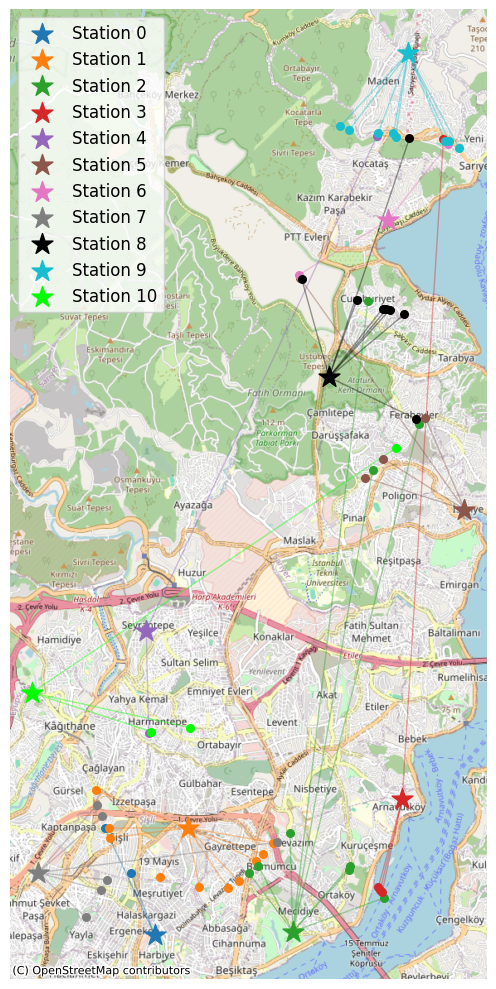

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors


demand = pd.read_csv('final_critical_demand_zones_80_for_success.csv')
stations = pd.read_csv('filtered_itfaiye.csv')


best_assignment = np.array([ 3, 2, 2, 1, 9, 5, 9, 9, 6, 0, 1, 3, 1, 6, 8, 3, 2, 8, 9, 5, 9, 9, 5, 8, 7, 8, 7, 8, 1, 1, 1, 9, 4, 8, 1, 8, 1, 9, 7, 8, 1, 2, 5, 4, 1, 2, 3, 7, 10, 7, 10, 10, 2, 2, 2, 2, 7, 0

 ]) 


gdf_demands = gpd.GeoDataFrame(
    demand,
    geometry=gpd.points_from_xy(demand['LONGITUDE'], demand['LATITUDE']),
    crs="EPSG:4326"
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Koordinat (Y)'], stations['Koordinat (X)']),
    crs="EPSG:4326"
)


gdf_demands = gdf_demands.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)



num_stations = len(gdf_stations)
cmap = cm.get_cmap('tab10', num_stations) if num_stations <= 10 else cm.get_cmap('tab20', num_stations)
colors = [mcolors.rgb2hex(cmap(i)) for i in range(num_stations)]


colors[8] = 'black'    
colors[10] = 'lime'       


fig, ax = plt.subplots(figsize=(12, 10))


for st_idx in range(num_stations):
    
    assigned_idx = np.where(best_assignment == st_idx)[0]
    color = colors[st_idx]

    
    gdf_demands.iloc[assigned_idx].plot(ax=ax, color=color, markersize=30, zorder=2)
    
    
    for i in assigned_idx:
        demand_point = gdf_demands.iloc[i].geometry
        station_point = gdf_stations.iloc[st_idx].geometry
        ax.plot([demand_point.x, station_point.x], [demand_point.y, station_point.y],
                color=color, alpha=0.4, linewidth=1, zorder=1)
    
    
    gdf_stations.iloc[[st_idx]].plot(ax=ax, color=color, marker='*', markersize=250, zorder=3, label=f'Station {st_idx}')


ctx.add_basemap(ax, crs=gdf_demands.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()


